# Data Pull

In [1]:
import pandas as pd
import requests
import datetime
import time
from typing import Dict, List, Optional

def fetch_season_results(year: int, result_type: str = 'results') -> Optional[Dict]:
    base_url = f"https://ergast.com/api/f1/{year}/{result_type}.json"
    all_results = []
    offset = 0
    limit = 1000  # Maximum allowed by the API

    while True:
        url = f"{base_url}?limit={limit}&offset={offset}"
        try:
            response = requests.get(url)
            time.sleep(0.25)  # Rate limiting
            response.raise_for_status()
            data = response.json()

            results = data['MRData']['RaceTable']['Races']
            all_results.extend(results)

            total = int(data['MRData']['total'])
            if offset + limit >= total:
                break

            offset += limit
        except requests.RequestException as e:
            print(f"Error fetching data for {year} {result_type}: {e}")
            return None

    return {'MRData': {'RaceTable': {'Races': all_results}}}

def process_results(results: Dict, year: int, result_type: str) -> List[Dict]:
    race_data = []
    for race in results.get('MRData', {}).get('RaceTable', {}).get('Races', []):
        race_info = {
            'Year': year,
            'Round': int(race.get('round', 0)),
            'RaceName': race.get('raceName', 'Unknown Race'),
            'Date': pd.to_datetime(race.get('date', 'Unknown Date')),
            'Time': race.get('time', None),
            'CircuitId': race.get('Circuit', {}).get('circuitId', 'Unknown Circuit'),
            'CircuitName': race.get('Circuit', {}).get('circuitName', 'Unknown Circuit'),
            'LocationLat': float(race.get('Circuit', {}).get('Location', {}).get('lat', 0)),
            'LocationLong': float(race.get('Circuit', {}).get('Location', {}).get('long', 0)),
            'Locality': race.get('Circuit', {}).get('Location', {}).get('locality', None),
            'Country': race.get('Circuit', {}).get('Location', {}).get('country', None),
            'ResultType': result_type
        }

        results_key = {
            'results': 'Results',
            'sprint': 'SprintResults',
            'qualifying': 'QualifyingResults'
        }.get(result_type, 'Results')

        for result in race.get(results_key, []):
            driver = result.get('Driver', {})
            constructor = result.get('Constructor', {})
            time_info = result.get('Time', {})
            fastest_lap = result.get('FastestLap', {})
            qualifying_times = {
                'Q1': result.get('Q1', None),
                'Q2': result.get('Q2', None),
                'Q3': result.get('Q3', None)
            }
            race_data.append({
                **race_info,
                'Position': int(result.get('position', 0)),
                'PositionText': result.get('positionText', None),
                'Points': float(result.get('points', 0)),
                'DriverId': driver.get('driverId', None),
                'DriverCode': driver.get('code', None),
                'DriverName': f"{driver.get('givenName', 'Unknown')} {driver.get('familyName', 'Unknown')}",
                'DriverDOB': pd.to_datetime(driver.get('dateOfBirth', None)),
                'DriverNationality': driver.get('nationality', None),
                'ConstructorId': constructor.get('constructorId', None),
                'ConstructorName': constructor.get('name', None),
                'ConstructorNationality': constructor.get('nationality', None),
                'Grid': int(result.get('grid', 0)),
                'Laps': int(result.get('laps', 0)),
                'Status': result.get('status', None),
                'Time': time_info.get('time', None),
                'Millis': int(time_info.get('millis', 0)) if time_info.get('millis') else None,
                'FastestLapTime': fastest_lap.get('Time', {}).get('time', None),
                'FastestLapLap': int(fastest_lap.get('lap', 0)) if fastest_lap.get('lap') else None,
                'FastestLapAverageSpeed': float(fastest_lap.get('AverageSpeed', {}).get('speed', 0)),
                **qualifying_times
            })
    return race_data

def fetch_f1_data(start_year: int, end_year: int) -> List[Dict]:
    all_race_results = []
    for year in range(start_year, end_year + 1):
        print(f"Fetching race data for {year}...")

        # Fetch entire season race results
        race_results = fetch_season_results(year, 'results')
        if race_results and race_results.get('MRData', {}).get('RaceTable', {}).get('Races', []):
            race_data = process_results(race_results, year, 'results')
            all_race_results.extend(race_data)
            print(f"Fetched race results for {year}.")

        # Fetch entire season sprint results if year is 2021 or later
        if year >= 2021:
            sprint_results = fetch_season_results(year, 'sprint')
            if sprint_results and sprint_results.get('MRData', {}).get('RaceTable', {}).get('Races', []):
                sprint_race_data = process_results(sprint_results, year, 'sprint')
                all_race_results.extend(sprint_race_data)
                print(f"Fetched sprint race results for {year}.")

        # Fetch entire season qualifying results
        qualifying_results = fetch_season_results(year, 'qualifying')
        if qualifying_results and qualifying_results.get('MRData', {}).get('RaceTable', {}).get('Races', []):
            qualifying_data = process_results(qualifying_results, year, 'qualifying')
            all_race_results.extend(qualifying_data)
            print(f"Fetched qualifying results for {year}.")

    return all_race_results

# Fetch data from 2017 to the present year
current_year = datetime.datetime.now().year
race_results = fetch_f1_data(2017, current_year)

# Convert the race results to a DataFrame
df_race_results = pd.DataFrame(race_results)

# Set display options
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

# Display the first few rows of the DataFrame
print(df_race_results.head(100))

# Display DataFrame info
print(df_race_results.info())

Fetching race data for 2017...
Fetched race results for 2017.
Fetched qualifying results for 2017.
Fetching race data for 2018...
Fetched race results for 2018.
Fetched qualifying results for 2018.
Fetching race data for 2019...
Fetched race results for 2019.
Fetched qualifying results for 2019.
Fetching race data for 2020...
Fetched race results for 2020.
Fetched qualifying results for 2020.
Fetching race data for 2021...
Fetched race results for 2021.
Fetched sprint race results for 2021.
Fetched qualifying results for 2021.
Fetching race data for 2022...
Fetched race results for 2022.
Fetched sprint race results for 2022.
Fetched qualifying results for 2022.
Fetching race data for 2023...
Fetched race results for 2023.
Fetched sprint race results for 2023.
Fetched qualifying results for 2023.
Fetching race data for 2024...
Fetched race results for 2024.
Fetched sprint race results for 2024.
Fetched qualifying results for 2024.
    Year  Round               RaceName       Date       

# Data Checks

1. Data Range:
Year range: 2017 to 2024
Number of unique years: 8

Distribution of entries by year:
Year
2017     798
2018     840
2019     838
2020     680
2021     939
2022     940
2023    1000
2024     438
Name: count, dtype: int64


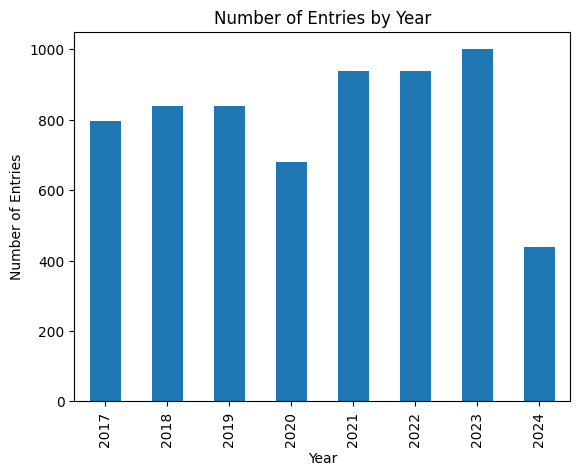


2. Consistency Checks:

Entries per race weekend:
ResultType  qualifying     results      sprint
count       155.000000  155.000000  155.000000
mean         19.961290   19.993548    1.806452
std           0.224588    0.080322    5.751450
min          18.000000   19.000000    0.000000
25%          20.000000   20.000000    0.000000
50%          20.000000   20.000000    0.000000
75%          20.000000   20.000000    0.000000
max          20.000000   20.000000   20.000000

Unique number of entries per result type:
ResultType
qualifying    22
results       22
sprint        13
Name: Round, dtype: int64

3. Result Types:
ResultType
results       3099
qualifying    3094
sprint         280
Name: count, dtype: int64


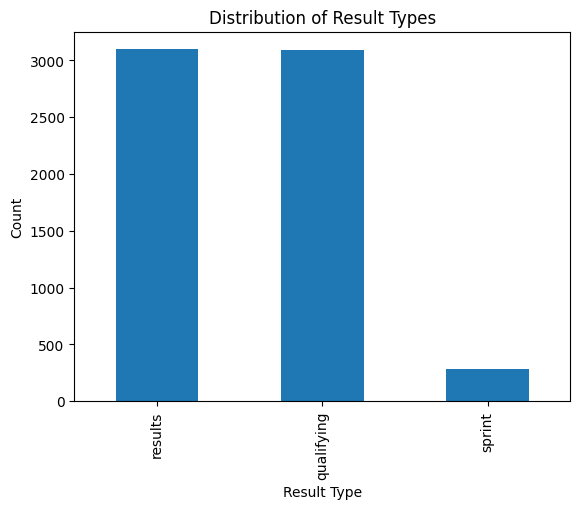


4. Missing Data:
Time              4551
PositionText      3094
Status            3094
Millis            4551
FastestLapTime    3252
FastestLapLap     3252
Q1                3379
Q2                4195
Q3                4960
dtype: int64

5. Unique Drivers and Constructors:
Number of unique drivers: 43
Number of unique constructors: 16

6. Points Distribution:
count    6473.000000
mean        2.490576
std         5.601683
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        26.000000
Name: Points, dtype: float64


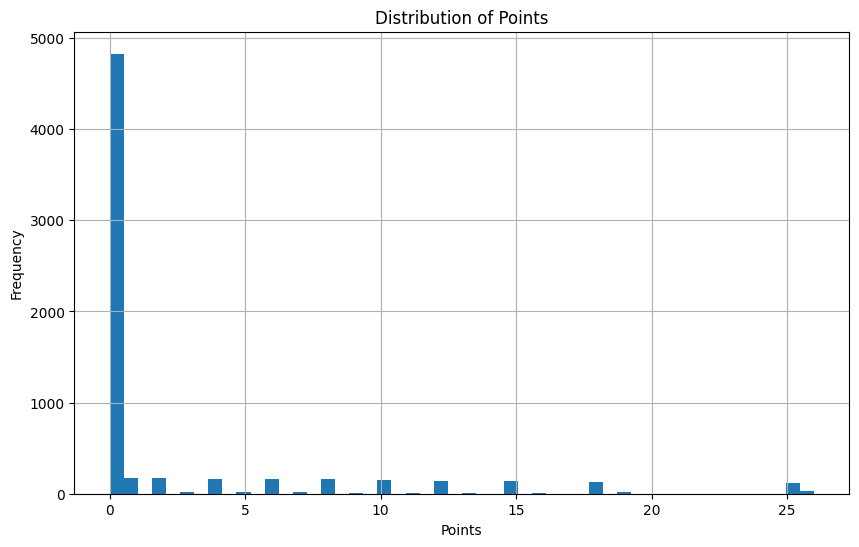


7. Top 10 Drivers by Total Points:
DriverName
Max Verstappen      2552.5
Lewis Hamilton      2462.5
Valtteri Bottas     1386.0
Sergio Pérez        1230.0
Charles Leclerc     1222.0
Carlos Sainz        1034.5
Sebastian Vettel     990.0
Lando Norris         783.0
Daniel Ricciardo     710.0
George Russell       550.0
Name: Points, dtype: float64

Top 10 Constructors by Total Points:
ConstructorName
Mercedes          4323.5
Red Bull          4057.5
Ferrari           3281.5
McLaren           1412.0
Aston Martin       470.0
Alpine F1 Team     456.0
Renault            451.0
AlphaTauri         309.0
Force India        298.0
Racing Point       283.0
Name: Points, dtype: float64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df_race_results
df = df_race_results

# 1. Verify Data Range
print("1. Data Range:")
print(f"Year range: {df['Year'].min()} to {df['Year'].max()}")
print(f"Number of unique years: {df['Year'].nunique()}")
print("\nDistribution of entries by year:")
year_counts = df['Year'].value_counts().sort_index()
print(year_counts)
year_counts.plot(kind='bar')
plt.title('Number of Entries by Year')
plt.xlabel('Year')
plt.ylabel('Number of Entries')
plt.show()

# 2. Check for Consistency
print("\n2. Consistency Checks:")
print("\nEntries per race weekend:")
race_counts = df.groupby(['Year', 'Round', 'ResultType']).size().unstack(fill_value=0)
print(race_counts.describe())

print("\nUnique number of entries per result type:")
print(df.groupby('ResultType')['Round'].nunique())

# 3. Result Types
print("\n3. Result Types:")
result_type_counts = df['ResultType'].value_counts()
print(result_type_counts)
result_type_counts.plot(kind='bar')
plt.title('Distribution of Result Types')
plt.xlabel('Result Type')
plt.ylabel('Count')
plt.show()

# 4. Missing Data
print("\n4. Missing Data:")
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0])

# 5. Unique Drivers and Constructors
print("\n5. Unique Drivers and Constructors:")
print(f"Number of unique drivers: {df['DriverId'].nunique()}")
print(f"Number of unique constructors: {df['ConstructorId'].nunique()}")

# 6. Points Distribution
print("\n6. Points Distribution:")
print(df['Points'].describe())
plt.figure(figsize=(10, 6))
df['Points'].hist(bins=50)
plt.title('Distribution of Points')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.show()

# 7. Top Drivers and Constructors
print("\n7. Top 10 Drivers by Total Points:")
top_drivers = df.groupby('DriverName')['Points'].sum().sort_values(ascending=False).head(10)
print(top_drivers)

print("\nTop 10 Constructors by Total Points:")
top_constructors = df.groupby('ConstructorName')['Points'].sum().sort_values(ascending=False).head(10)
print(top_constructors)

In [ ]:

import pandas as pd

# Display all columns in the DataFrame
print("Columns in DataFrame:")
print(df_race_results.columns)

# Display unique values for each column
for column in df_race_results.columns:
    unique_values = df_race_results[column].unique()
    print(f"\nColumn: {column}")
    print(f"Unique values ({len(unique_values)}): {unique_values[:60]}")  # Display first 10 unique values

# Save the unique values summary to a CSV file for further inspection
summary = {column: df_race_results[column].unique() for column in df_race_results.columns}
df_summary = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in summary.items()]))



Columns in DataFrame:
Index(['Year', 'Round', 'RaceName', 'Date', 'Time', 'CircuitId', 'CircuitName',
       'LocationLat', 'LocationLong', 'Locality', 'Country', 'ResultType',
       'Position', 'PositionText', 'Points', 'DriverId', 'DriverCode',
       'DriverName', 'DriverDOB', 'DriverNationality', 'ConstructorId',
       'ConstructorName', 'ConstructorNationality', 'Grid', 'Laps', 'Status',
       'Millis', 'FastestLapTime', 'Q1', 'Q2', 'Q3'],
      dtype='object')

Column: Year
Unique values (8): [2017 2018 2019 2020 2021 2022 2023 2024]

Column: Round
Unique values (22): ['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16'
 '17' '18' '19' '20' '21' '22']

Column: RaceName
Unique values (37): ['Australian Grand Prix' 'Chinese Grand Prix' 'Bahrain Grand Prix'
 'Russian Grand Prix' 'Spanish Grand Prix' 'Monaco Grand Prix'
 'Canadian Grand Prix' 'Azerbaijan Grand Prix' 'Austrian Grand Prix'
 'British Grand Prix' 'Hungarian Grand Prix' 'Belgian Grand Prix'
 'Italian

# Calculate Fantasy Points

In [20]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

def process_status(status):
    if pd.isna(status):
        return 'Unknown'
    if status == 'Finished':
        return 'Finished'
    elif status.startswith('+') and 'Lap' in status:
        return 'Lapped'
    else:
        return 'DNF'

def safe_float(value):
    try:
        return float(value)
    except (ValueError, TypeError):
        return None

def time_to_seconds(time_str):
    if pd.isna(time_str) or time_str == '':
        return None
    parts = time_str.split(':')
    if len(parts) == 2:
        return safe_float(parts[0]) * 60 + safe_float(parts[1])
    elif len(parts) == 1:
        return safe_float(parts[0])
    return None

def score_fantasy_points(df):
    df = df.copy()

    # Ensure required columns exist and are of correct type
    df['Grid'] = pd.to_numeric(df['Grid'], errors='coerce')
    df['Position'] = pd.to_numeric(df['Position'], errors='coerce')

    # Process Status column
    df['ProcessedStatus'] = df['Status'].fillna('Unknown').apply(process_status)

    # Convert FastestLapTime to seconds
    df['FastestLapSeconds'] = df['FastestLapTime'].apply(time_to_seconds)

    # Determine FastestLap
    df['FastestLap'] = df.groupby(['Year', 'Round'])['FastestLapSeconds'].transform(lambda x: x == x.min())

    # Calculate qualifying performance
    def get_best_qualifying_time(row):
        times = [time_to_seconds(row['Q1']), time_to_seconds(row['Q2']), time_to_seconds(row['Q3'])]
        valid_times = [t for t in times if t is not None]
        return min(valid_times) if valid_times else None

    df['QualifyingPerformance'] = df.apply(get_best_qualifying_time, axis=1)

    # Calculate positions gained/lost
    df['PositionsGained'] = df['Grid'] - df['Position']

    # Calculate driver points
    def calculate_qualifying_points(row):
        position = row['Position']
        points = {1: 10, 2: 9, 3: 8, 4: 7, 5: 6, 6: 5, 7: 4, 8: 3, 9: 2, 10: 1}.get(position, 0)

        if row['ProcessedStatus'] == 'DNF':
            points -= 5
        elif pd.isna(row['Q1']) or row['Q1'] == 'None':
            points -= 5

        return points

    def calculate_sprint_points(row):
        position = row['Position']
        points = {1: 8, 2: 7, 3: 6, 4: 5, 5: 4, 6: 3, 7: 2, 8: 1}.get(position, 0)

        points += max(row['PositionsGained'], 0)  # Points for positions gained

        if row['FastestLap']:
            points += 5

        if row['ProcessedStatus'] == 'DNF':
            points -= 20

        return points

    def calculate_race_points(row):
        position = row['Position']
        points = {1: 25, 2: 18, 3: 15, 4: 12, 5: 10, 6: 8, 7: 6, 8: 4, 9: 2, 10: 1}.get(position, 0)

        points += max(row['PositionsGained'], 0)  # Points for positions gained

        if row['FastestLap']:
            points += 10

        if row['ProcessedStatus'] == 'DNF':
            points -= 20

        return points

    df['DriverPoints'] = 0
    mask_qualifying = df['ResultType'] == 'qualifying'
    mask_sprint = df['ResultType'] == 'sprint'
    mask_race = df['ResultType'] == 'results'

    df.loc[mask_qualifying, 'DriverPoints'] = df[mask_qualifying].apply(calculate_qualifying_points, axis=1)
    df.loc[mask_sprint, 'DriverPoints'] = df[mask_sprint].apply(calculate_sprint_points, axis=1)
    df.loc[mask_race, 'DriverPoints'] = df[mask_race].apply(calculate_race_points, axis=1)

    # Calculate constructor points
    def calculate_constructor_points(group):
        qualifying_group = group[group['ResultType'] == 'qualifying']
        sprint_group = group[group['ResultType'] == 'sprint']
        race_group = group[group['ResultType'] == 'results']

        qualifying_points = qualifying_group['DriverPoints'].sum()
        q2_drivers = (qualifying_group['Q2'].notna() & (qualifying_group['Q2'] != 'None')).sum()
        q3_drivers = (qualifying_group['Q3'].notna() & (qualifying_group['Q3'] != 'None')).sum()

        if q2_drivers == 0:
            qualifying_points -= 1
        elif q2_drivers == 1:
            qualifying_points += 1
        elif q2_drivers == 2:
            qualifying_points += 3

        if q3_drivers == 1:
            qualifying_points += 5
        elif q3_drivers == 2:
            qualifying_points += 10

        sprint_points = sprint_group['DriverPoints'].sum()
        race_points = race_group['DriverPoints'].sum()

        return pd.Series({
            'QualifyingConstructorPoints': qualifying_points,
            'SprintConstructorPoints': sprint_points,
            'RaceConstructorPoints': race_points
        })

    constructor_points = df.groupby(['Year', 'Round', 'ConstructorId']).apply(calculate_constructor_points).reset_index()

    # Aggregate data at the round level
    round_summary = df.groupby(['Year', 'Round', 'DriverId', 'ConstructorId', 'ResultType'])['DriverPoints'].sum().reset_index()

    # Pivot the data to have qualifying, sprint, and race points in separate columns
    driver_summary = round_summary.pivot(index=['Year', 'Round', 'DriverId', 'ConstructorId'],
                                         columns='ResultType',
                                         values='DriverPoints').reset_index()
    driver_summary.columns.name = None
    driver_summary = driver_summary.rename(columns={
        'qualifying': 'QualifyingPoints',
        'sprint': 'SprintPoints',
        'results': 'RacePoints'
    })

    # Calculate total driver points
    driver_summary['TotalDriverPoints'] = driver_summary['QualifyingPoints'].fillna(0) + \
                                          driver_summary['SprintPoints'].fillna(0) + \
                                          driver_summary['RacePoints'].fillna(0)

    # Create a separate dataframe for constructor points
    constructor_summary = constructor_points.copy()
    constructor_summary['TotalConstructorPoints'] = constructor_summary['QualifyingConstructorPoints'] + \
                                                    constructor_summary['SprintConstructorPoints'] + \
                                                    constructor_summary['RaceConstructorPoints']

    # Merge additional columns back into driver_summary
    additional_columns = ['RaceName', 'Date', 'Time', 'CircuitId', 'CircuitName', 'LocationLat', 'LocationLong',
                          'Locality', 'Country', 'ResultType', 'Position', 'PositionText', 'Points', 'DriverCode',
                          'DriverName', 'DriverDOB', 'DriverNationality', 'ConstructorName', 'ConstructorNationality',
                          'Grid', 'Laps', 'ProcessedStatus', 'Millis', 'FastestLapTime', 'FastestLapLap', 'FastestLapAverageSpeed',
                          'Q1', 'Q2', 'Q3', 'FastestLap', 'QualifyingPerformance', 'PositionsGained']

    # Dropping duplicates before the merge to avoid conflicts
    df_additional = df.drop_duplicates(subset=['Year', 'Round', 'DriverId', 'ConstructorId'])

    # Merge additional columns back into driver_summary
    driver_summary = pd.merge(driver_summary, df_additional[['Year', 'Round', 'DriverId', 'ConstructorId'] + additional_columns],
                              on=['Year', 'Round', 'DriverId', 'ConstructorId'], how='left')

    return driver_summary, constructor_summary, df

# Calculate fantasy points
driver_summary, constructor_summary, detailed_df = score_fantasy_points(df_race_results)

# Combine driver_summary and constructor_summary
full_df = pd.merge(driver_summary, constructor_summary, on=['Year', 'Round', 'ConstructorId'], suffixes=('_driver', '_constructor'))

# Sort the dataframe by Year and Round
full_df = full_df.sort_values(['Year', 'Round'])

# Add any missing columns that are required for prediction
full_df['DayOfYear'] = pd.to_datetime(full_df['Date']).dt.dayofyear
full_df['MonthOfYear'] = pd.to_datetime(full_df['Date']).dt.month

# Calculate lag features
for lag in [1, 2, 3]:
    full_df[f'TotalDriverPoints_lag_{lag}'] = full_df.groupby('DriverId')['TotalDriverPoints'].shift(lag)
    full_df[f'TotalConstructorPoints_lag_{lag}'] = full_df.groupby('ConstructorId')['TotalConstructorPoints'].shift(lag)

# Calculate rolling average features
for window in [3, 5, 10]:
    full_df[f'DriverPoints_roll_{window}'] = full_df.groupby('DriverId')['TotalDriverPoints'].rolling(window=window, min_periods=1).mean().reset_index(0, drop=True)
    full_df[f'ConstructorPoints_roll_{window}'] = full_df.groupby('ConstructorId')['TotalConstructorPoints'].rolling(window=window, min_periods=1).mean().reset_index(0, drop=True)

# Calculate driver's historical performance at each track without data leakage
full_df['DriverTrackPerformance'] = full_df.groupby(['DriverId', 'CircuitId'])['Position'].transform(
    lambda x: x.shift().expanding().mean()
)

# Fill NaN values with 0 for the newly created features
full_df = full_df.fillna(0)

print(full_df.head())
print(full_df.columns)

# Save the full_df for use in the next cell
full_df.to_csv('full_df.csv', index=False)

   Year  Round   DriverId ConstructorId  QualifyingPoints  RacePoints  SprintPoints  TotalDriverPoints               RaceName       Date     Time    CircuitId                     CircuitName  LocationLat  LocationLong   Locality    Country ResultType  Position PositionText  Points DriverCode         DriverName  DriverDOB DriverNationality  ... Q1 Q2  Q3  FastestLap QualifyingPerformance  PositionsGained QualifyingConstructorPoints  SprintConstructorPoints  RaceConstructorPoints  TotalConstructorPoints  DayOfYear  MonthOfYear  TotalDriverPoints_lag_1  TotalConstructorPoints_lag_1  TotalDriverPoints_lag_2  TotalConstructorPoints_lag_2  TotalDriverPoints_lag_3  TotalConstructorPoints_lag_3  DriverPoints_roll_3  ConstructorPoints_roll_3  DriverPoints_roll_5  ConstructorPoints_roll_5  DriverPoints_roll_10  ConstructorPoints_roll_10  DriverTrackPerformance
0  2017      1     alonso       mclaren              -5.0       -20.0           0.0              -25.0  Australian Grand Prix 2017-03-26 

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
import warnings
import json
import os

warnings.filterwarnings('ignore')

# Load the full_df from the previous cell
full_df = pd.read_csv('full_df.csv')

# Define features for the model
numeric_features = ['TotalDriverPoints_lag_1', 'TotalDriverPoints_lag_2', 'TotalDriverPoints_lag_3',
                    'TotalConstructorPoints_lag_1', 'TotalConstructorPoints_lag_2', 'TotalConstructorPoints_lag_3',
                    'DriverPoints_roll_3', 'DriverPoints_roll_5', 'DriverPoints_roll_10',
                    'ConstructorPoints_roll_3', 'ConstructorPoints_roll_5', 'ConstructorPoints_roll_10',
                    'DriverTrackPerformance', 'Grid', 'QualifyingPerformance']

categorical_features = ['Year', 'Round', 'DayOfYear', 'MonthOfYear', 'DriverId', 'ConstructorId', 'CircuitId']

# Prepare the data for modeling
X = full_df[numeric_features + categorical_features]
y = full_df['TotalDriverPoints']

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Define models
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'LightGBM': LGBMRegressor(random_state=42, verbose=-1),  # Set verbose to -1 to suppress warnings
    'LinearRegression': LinearRegression()
}

# Hyperparameter grids for tuning
param_grids = {
    'RandomForest': {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__max_depth': [None, 10, 20, 30],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 4]
    },
    'GradientBoosting': {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__learning_rate': [0.01, 0.1, 0.2],
        'regressor__max_depth': [3, 4, 5]
    },
    'XGBoost': {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__learning_rate': [0.01, 0.1, 0.2],
        'regressor__max_depth': [3, 4, 5]
    },
    'LightGBM': {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__learning_rate': [0.01, 0.1, 0.2],
        'regressor__max_depth': [3, 4, 5],
        'regressor__num_leaves': [31, 63, 127]  # Add num_leaves parameter
    }
}

# Time-based cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Function to save best parameters
def save_best_params(best_params):
    with open('best_params.json', 'w') as f:
        json.dump(best_params, f)

# Function to load best parameters
def load_best_params():
    if os.path.exists('best_params.json'):
        with open('best_params.json', 'r') as f:
            return json.load(f)
    return None

# Ask user if they want to use saved parameters or perform new optimization
use_saved_params = input("Do you want to use saved hyperparameters? (y/n): ").lower() == 'y'

if use_saved_params:
    best_params = load_best_params()
    if best_params is None:
        print("No saved parameters found. Performing new optimization.")
        use_saved_params = False
    else:
        print("Using saved parameters.")
else:
    print("Performing new hyperparameter optimization.")

# Train and tune models
tuned_models = {}
model_performances = {}

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    if name in param_grids and not use_saved_params:
        print(f"Tuning {name}...")
        search = RandomizedSearchCV(pipeline, param_grids[name], n_iter=10, cv=tscv, scoring='neg_mean_squared_error', random_state=42, verbose=2)
        search.fit(X, y)
        tuned_models[name] = search.best_estimator_
        print(f"Best parameters for {name}: {search.best_params_}")

        # Save best parameters
        if 'best_params' not in locals():
            best_params = {}
        best_params[name] = search.best_params_
    else:
        print(f"Training {name}...")
        if use_saved_params and name in best_params:
            pipeline.set_params(**best_params[name])
        pipeline.fit(X, y)
        tuned_models[name] = pipeline

    # Evaluate model performance
    cv_scores = []
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        y_pred = tuned_models[name].predict(X_test)
        cv_scores.append(r2_score(y_test, y_pred))
    model_performances[name] = np.mean(cv_scores)
    print(f"{name} - Average R2 score: {model_performances[name]:.4f}")

# Save best parameters if new optimization was performed
if not use_saved_params:
    save_best_params(best_params)

# Calculate ensemble weights based on model performance
total_performance = sum(model_performances.values())
ensemble_weights = {name: performance / total_performance for name, performance in model_performances.items()}

print("\nEnsemble weights:")
for name, weight in ensemble_weights.items():
    print(f"{name}: {weight:.4f}")

def ensemble_predict(X, models, weights):
    predictions = np.zeros(X.shape[0])
    for name, model in models.items():
        predictions += weights[name] * model.predict(X)
    return predictions

def predict_future_performance(full_df, year, round_num, circuit_id):
    # Get the most recent race data
    last_race = full_df[full_df['Year'] == full_df['Year'].max()].groupby('DriverId').last().reset_index()

    # Create future data for each active driver with their most recent constructor
    future_data = last_race[['DriverId', 'ConstructorId']].copy()
    future_data['Year'] = year
    future_data['Round'] = round_num
    future_data['CircuitId'] = circuit_id
    future_data['DayOfYear'] = (pd.to_datetime(f"{year}-03-01") + pd.Timedelta(days=7*(round_num-1))).dayofyear
    future_data['MonthOfYear'] = (pd.to_datetime(f"{year}-03-01") + pd.Timedelta(days=7*(round_num-1))).month

    # Add lag and rolling features (use the most recent values from full_df)
    for feature in numeric_features:
        if feature not in future_data.columns:
            future_data[feature] = last_race[feature]

    # Handle new drivers or driver changes
    mean_driver_performance = full_df['TotalDriverPoints'].mean()
    for feature in ['TotalDriverPoints_lag_1', 'TotalDriverPoints_lag_2', 'TotalDriverPoints_lag_3',
                    'DriverPoints_roll_3', 'DriverPoints_roll_5', 'DriverPoints_roll_10']:
        future_data[feature] = future_data[feature].fillna(mean_driver_performance)

    # Set default values for categorical features
    future_data['ProcessedStatus'] = 'Unknown'
    future_data['Grid'] = 0
    future_data['QualifyingPerformance'] = future_data['QualifyingPerformance'].fillna(0)

    # Make predictions
    predictions = ensemble_predict(future_data, tuned_models, ensemble_weights)

    return predictions, future_data

# Print CircuitIDs for each round from the previous year
previous_year = full_df['Year'].max() - 1
previous_year_circuits = full_df[full_df['Year'] == previous_year][['Round', 'CircuitId']].drop_duplicates().sort_values('Round')
print("\nCircuitIDs for each round from the previous year:")
print(previous_year_circuits)

# Ask for CircuitID for the predicted round
next_year = full_df['Year'].max()
next_round = full_df[full_df['Year'] == next_year]['Round'].max() + 1
if next_round > 20:  # Assuming a season typically has around 20 races
    next_year += 1
    next_round = 1

circuit_id = input(f"\nEnter the CircuitID for Year {next_year}, Round {next_round}: ")

print(f"\nPredicting for Year: {next_year}, Round: {next_round}, CircuitId: {circuit_id}")
predictions, future_data = predict_future_performance(full_df, next_year, next_round, circuit_id)

# Create DataFrame for predictions
predictions_df = future_data[['DriverId', 'ConstructorId']].copy()
predictions_df['PredictedPoints'] = predictions
predictions_df = predictions_df.sort_values('PredictedPoints', ascending=False)

print("\nPredicted points for active drivers in the next race:")
print(predictions_df)

predictions_df.to_csv('driver_predictions.csv', index=False)

Do you want to use saved hyperparameters? (y/n): n
Performing new hyperparameter optimization.
Tuning RandomForest...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END regressor__max_depth=20, regressor__min_samples_leaf=4, regressor__min_samples_split=5, regressor__n_estimators=300; total time=   1.9s
[CV] END regressor__max_depth=20, regressor__min_samples_leaf=4, regressor__min_samples_split=5, regressor__n_estimators=300; total time=   4.8s
[CV] END regressor__max_depth=20, regressor__min_samples_leaf=4, regressor__min_samples_split=5, regressor__n_estimators=300; total time=   8.4s
[CV] END regressor__max_depth=20, regressor__min_samples_leaf=4, regressor__min_samples_split=5, regressor__n_estimators=300; total time=  12.9s
[CV] END regressor__max_depth=20, regressor__min_samples_leaf=4, regressor__min_samples_split=5, regressor__n_estimators=300; total time=  18.3s
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=2, regressor__min_samples_split=

In [28]:
import pandas as pd
import itertools

# Load predictions
predictions_df = pd.read_csv('driver_predictions.csv')

# Driver prices
driver_prices = {
    'max_verstappen': 30.9,
    'norris': 26.0,
    'leclerc': 23.3,
    'sainz': 21.9,
    'piastri': 22.0,
    'russell': 21.4,
    'perez': 22.6,
    'hamilton': 21.8,
    'alonso': 16.5,
    'kevin_magnussen': 10.3,
    'tsunoda': 10.0,
    'hulkenberg': 9.2,
    'stroll': 14.6,
    'gasly': 10.1,
    'ocon': 10.0,
    'zhou': 7.7,
    'bottas': 7.8,
    'ricciardo': 10.4,
    'sargeant': 5.3,
    'albon': 8.5
}

# Function to get valid driver combinations
def get_valid_combinations(budget, num_drivers=5):
    drivers = list(driver_prices.keys())
    valid_combinations = []

    for combo in itertools.combinations(drivers, num_drivers):
        total_cost = sum(driver_prices[driver] for driver in combo)
        if total_cost <= budget:
            valid_combinations.append(combo)

    return valid_combinations

# Function to calculate total points for a combination
def calculate_total_points(combo, predictions_df):
    total_points = 0
    for driver in combo:
        driver_points = predictions_df[predictions_df['DriverId'] == driver]['PredictedPoints'].values
        if len(driver_points) > 0:
            total_points += driver_points[0]
    return total_points

# Main optimization function
def optimize_lineup(budget, num_drivers=5):
    valid_combinations = get_valid_combinations(budget, num_drivers)

    best_combos = []
    for combo in valid_combinations:
        total_cost = sum(driver_prices[driver] for driver in combo)
        total_points = calculate_total_points(combo, predictions_df)
        best_combos.append((combo, total_points, total_cost))

    best_combos.sort(key=lambda x: x[1], reverse=True)

    return best_combos[:10]  # Return top 10 combinations

# Get user input
budget = float(input("Enter your budget for drivers: "))

# Run optimization
best_lineups = optimize_lineup(budget)

# Print results
print("\nTop 10 driver lineups:")
for i, (combo, points, cost) in enumerate(best_lineups, 1):
    print(f"{i}. Drivers: {', '.join(combo)}")
    print(f"   Predicted Points: {points:.2f}")
    print(f"   Total Cost: ${cost:.2f}")
    print(f"   Remaining Budget: ${budget - cost:.2f}")
    print()

# Suggest lineups slightly over and under budget
over_budget = optimize_lineup(budget * 1.05)  # 5% over budget
under_budget = optimize_lineup(budget * 0.95)  # 5% under budget

print("Lineup suggestion slightly over budget:")
combo, points, cost = over_budget[0]
print(f"Drivers: {', '.join(combo)}")
print(f"Predicted Points: {points:.2f}")
print(f"Total Cost: ${cost:.2f}")
print(f"Over Budget by: ${cost - budget:.2f}")

print("\nLineup suggestion slightly under budget:")
combo, points, cost = under_budget[0]
print(f"Drivers: {', '.join(combo)}")
print(f"Predicted Points: {points:.2f}")
print(f"Total Cost: ${cost:.2f}")
print(f"Under Budget by: ${budget - cost:.2f}")

Enter your budget for drivers: 81.5

Top 10 driver lineups:
1. Drivers: piastri, russell, hamilton, hulkenberg, sargeant
   Predicted Points: 58.41
   Total Cost: $79.70
   Remaining Budget: $1.80

2. Drivers: sainz, piastri, russell, hulkenberg, sargeant
   Predicted Points: 57.39
   Total Cost: $79.80
   Remaining Budget: $1.70

3. Drivers: piastri, russell, hamilton, kevin_magnussen, sargeant
   Predicted Points: 56.39
   Total Cost: $80.80
   Remaining Budget: $0.70

4. Drivers: sainz, piastri, russell, kevin_magnussen, sargeant
   Predicted Points: 55.36
   Total Cost: $80.90
   Remaining Budget: $0.60

5. Drivers: piastri, russell, hamilton, ricciardo, sargeant
   Predicted Points: 53.89
   Total Cost: $80.90
   Remaining Budget: $0.60

6. Drivers: piastri, russell, alonso, kevin_magnussen, hulkenberg
   Predicted Points: 53.69
   Total Cost: $79.40
   Remaining Budget: $2.10

7. Drivers: sainz, piastri, russell, ricciardo, sargeant
   Predicted Points: 52.87
   Total Cost: $81.0